# Task 4: Explainability through Grad-CAM

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import importlib
import keras
import numpy as np
import random

from keras.layers import Conv2D

# Import the modules normally
import src.loading as loading
import src.models as models

# Reload the modules to overwrite any previously imported functions
importlib.reload(loading)
importlib.reload(models)

<module 'src.models' from 'c:\\Users\\Carlo\\Documents\\2024-2025\\SEMESTER_2\\Artificial Intelligence\\AI-project\\AI-project\\notebooks\\src\\models.py'>

## 1. Grad-CAM implementation:

In [171]:
# Load your best-performing model according to test performance.
model = keras.models.load_model('../results/final_baseline.keras')  # Our best-performing model is the baseline model
model.summary()

Model: "functional_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_36 (InputLayer)     │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_108 (Conv2D)             │ (None, 128, 128, 8)    │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_108               │ (None, 64, 64, 8)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_72 (Dropout)            │ (None, 64, 64, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_109 (Conv2D)             │ (None, 64, 64, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_109               │ (None, 32, 32, 16)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_110 (Conv2D)             │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_110               │ (None, 16, 16, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_73 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_36 (Flatten)            │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,603,653 (48.08 MB)

 Trainable params: 4,201,217 (16.03 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,402,436 (32.05 MB)

In [172]:
# Remove the final activation if present.
model.layers[-1].activation = None
print(f'Last layer ({model.layers[-1].name}) has it\'s activation removed: {model.layers[-1].activation == None}')

Last layer (dense_73) has it's activation removed: True


In [183]:
# Select a test sample and pre-process it.
img_height, img_width = 128, 128
batch_size = 200
path = "../data"
_, _, _, test_data_gen = loading.get_images(
    path,
    img_height,
    img_width,
    batch_size,
    norm="training",    # Same normilization we used in training
)

test_batch = next(iter(test_data_gen))
index = -1
test_image = test_batch[0][index]
input_image = tf.expand_dims(test_image, axis=0)

Found 1600 files belonging to 2 classes.
Found 400 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.
Found 200 files belonging to 2 classes.


c:\Users\Carlo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_36']
Received: inputs=Tensor(shape=(1, 128, 128, 1))
  warnings.warn(msg)


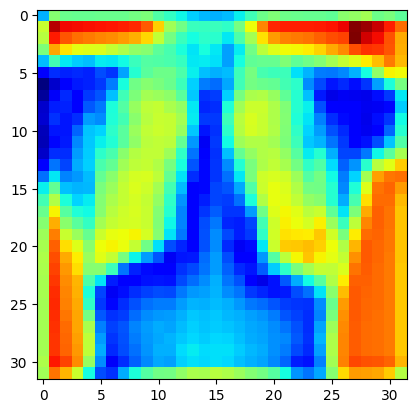

In [184]:
def make_gradcam_heatmap(input_image, model):
    """
    Generates a Grad-CAM heatmap for a given input image and model. Calculates the last convolutional layer's output and its gradients with respect to the input image.

    Parameters
    ----------
    input_image : tensorflow.EagerTensor
        Preprocessed input image
    model : keras.Sequential
        Pretrained Keras model
    Returns
    -------
    heatmap : tensorflow.EagerTensor
        Heatmap of shape (H, W)
    """
    # Evaluate the model and obtain the last convolutional layer’s output.
    last_conv_layer = None
    for layer in model.layers:
        if isinstance(layer, Conv2D):
            last_conv_layer = layer
    activation = last_conv_layer.activation
    last_conv_layer.activation = None      # Temporarily disable activation to avoid problems we've faced
            
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[last_conv_layer.output, model.output]
    )

    with tf.GradientTape() as tape:
            tape.watch(input_image)
            last_conv_layer_output, preds = grad_model(input_image)
            prediction_class = preds[:, 0]
    
    grads = tape.gradient(prediction_class, last_conv_layer_output)  # Shape: (1, h, w, c)

    last_conv_layer.activation = activation
    
    # Average the gradients along the spatial dimension to get a proxy for the channel importance.
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Obtain a heatmap by averaging the activations along the channel dimension,
    # weighting each channel according to its importance (i.e., use the averaged gradients from the previous step as weights).
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap between 0 and 1.
    heatmap = heatmap.numpy()
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    return heatmap
    
heatmap = make_gradcam_heatmap(input_image, model)
plt.imshow(heatmap, cmap='jet')

In [185]:
def display_gradcam(test_image, heatmap, save_path = None, alpha : float=0.4) -> None:
    '''
    Displays the original test image next to the (overlayed) grad-CAM heatmap.

    Parameters
    ----------
    test_image : tensorflow.EagerTensor
        Preprocessed input image
    heatmap : tensorflow.EagerTensor
        Heatmap of shape (H, W)
    alpha : float, optional
        Alpha value for the heatmap overlay. Default is 0.4.
    '''
    # Map the heatmap onto the original sample space, accounting for the image size and value range.
    heatmap = np.uint8(255.0 * heatmap)

    jet = mpl.colormaps["jet"]

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((test_image.shape[1], test_image.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Normalize test_image to the range [0, 255].
    test_image = (test_image - tf.reduce_min(test_image)) / (tf.reduce_max(test_image) - tf.reduce_min(test_image))
    test_image = test_image * 255.0

    # Overlay the heatmap on the original image, by adding to its values rescaled by 0.4, and plot it.
    superimposed_test_image = jet_heatmap * alpha + test_image * (1 - alpha)
    superimposed_test_image = keras.utils.array_to_img(superimposed_test_image)

    plt.subplot(1, 2, 1)
    plt.imshow(test_image, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_test_image)
    plt.title("Grad-CAM Heatmap")
    plt.axis('off')

    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi=300)
    plt.show()

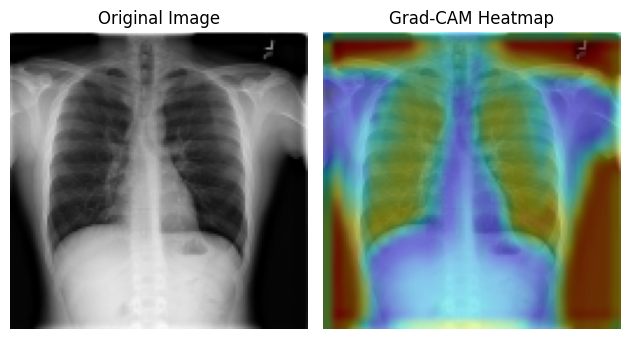

In [ ]:
test_image = test_batch[0][index]
true_label = test_batch[1][index]
input_image = tf.convert_to_tensor(tf.expand_dims(test_image, axis=0), dtype=tf.float32)
heatmap = make_gradcam_heatmap(input_image, model)
display_gradcam(test_image, heatmap, save_path = "../../Report_group25/Images/gradcam.png", alpha = 0.4)

## 2. Explaining the decision with Grad-CAM

In [187]:
# Predict labels for the entire test dataset
all_test_images = np.concatenate([batch[0] for batch in test_data_gen], axis=0)
all_test_labels = np.concatenate([batch[1] for batch in test_data_gen], axis=0).flatten()

# Flatten predictions
pred_probs = model.predict(test_data_gen)
pred_labels = (pred_probs > 0.5).astype(int).flatten() # look at the sigmoid output and make it a binary prediction

# Identify misclassified and correctly classified samples
misclassified_indices = np.where(pred_labels != all_test_labels)[0]
correctly_classified_indices = np.where(pred_labels == all_test_labels)[0]

# Group samples by true and predicted labels
group_1 = misclassified_indices[(all_test_labels[misclassified_indices] == 0) & (pred_labels[misclassified_indices] == 1)]
group_2 = misclassified_indices[(all_test_labels[misclassified_indices] == 1) & (pred_labels[misclassified_indices] == 0)]
group_3 = correctly_classified_indices[all_test_labels[correctly_classified_indices] == 0]  # True: 0, Pred: 0
group_4 = correctly_classified_indices[all_test_labels[correctly_classified_indices] == 1]  # True: 1, Pred: 1

# Print group sizes
for i, group in enumerate([group_1, group_2, group_3, group_4], start=1):
    print(f"Group {i}: {len(group)} samples")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
Group 1: 16 samples
Group 2: 14 samples
Group 3: 84 samples
Group 4: 86 samples



Visualizing Grad-CAM for Group 1...
Sample Index: 97, True Label: 0.0, Predicted Label: 1


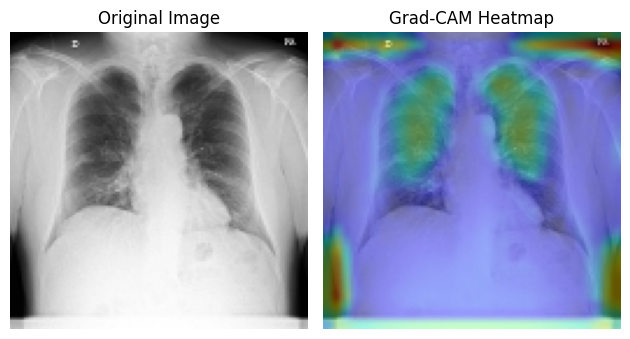

Sample Index: 77, True Label: 0.0, Predicted Label: 1


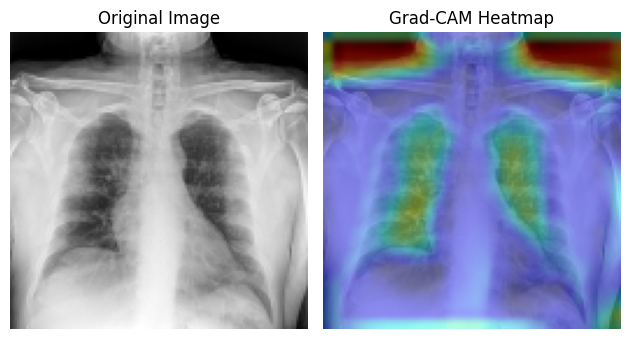

Sample Index: 42, True Label: 0.0, Predicted Label: 1


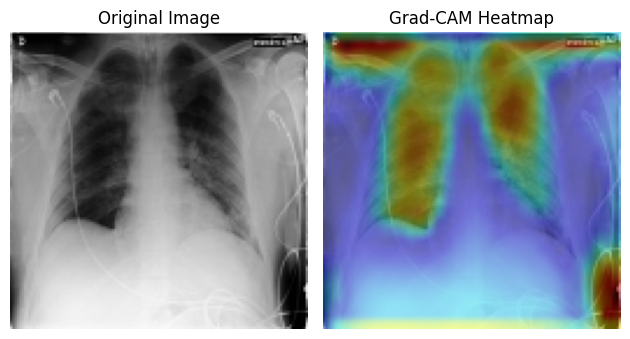


Visualizing Grad-CAM for Group 2...
Sample Index: 196, True Label: 1.0, Predicted Label: 0


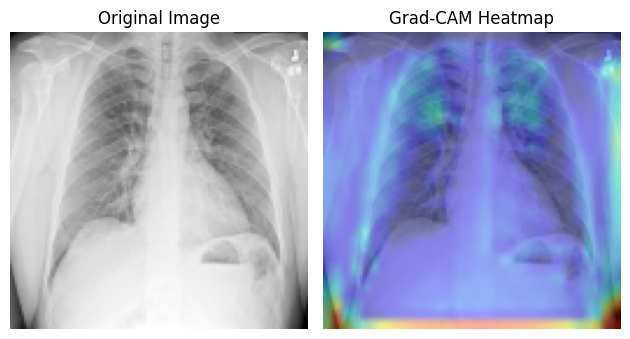

Sample Index: 121, True Label: 1.0, Predicted Label: 0


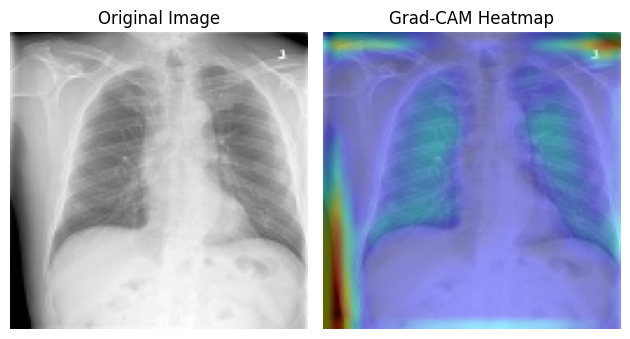

Sample Index: 152, True Label: 1.0, Predicted Label: 0


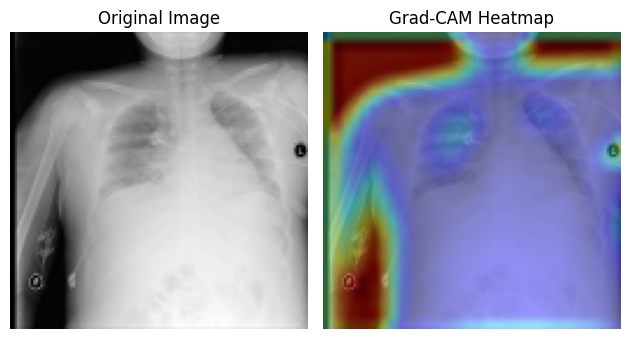


Visualizing Grad-CAM for Group 3...
Sample Index: 84, True Label: 0.0, Predicted Label: 0


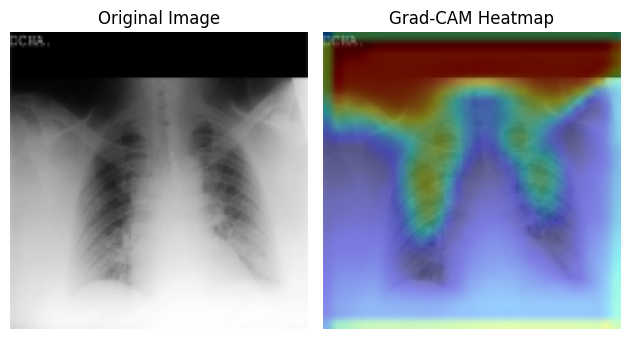

Sample Index: 49, True Label: 0.0, Predicted Label: 0


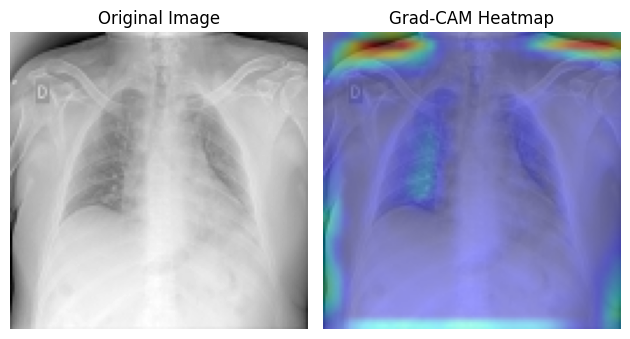

Sample Index: 54, True Label: 0.0, Predicted Label: 0


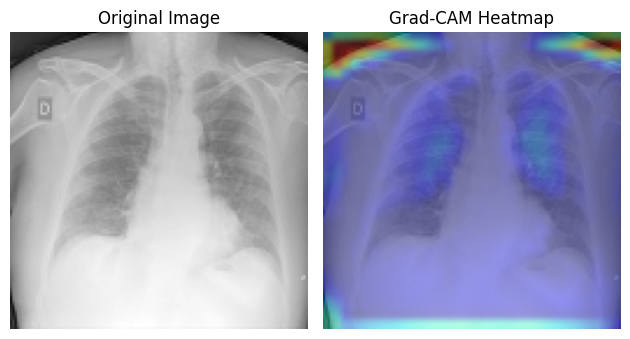


Visualizing Grad-CAM for Group 4...
Sample Index: 137, True Label: 1.0, Predicted Label: 1


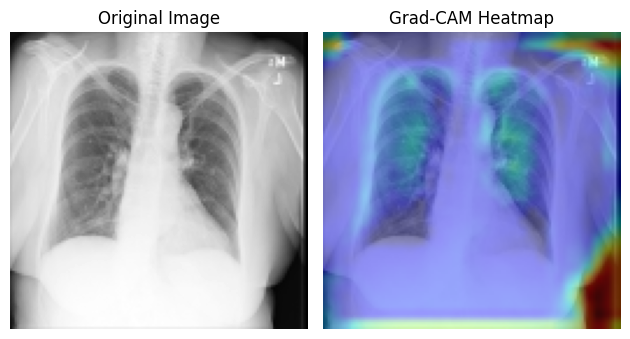

Sample Index: 193, True Label: 1.0, Predicted Label: 1


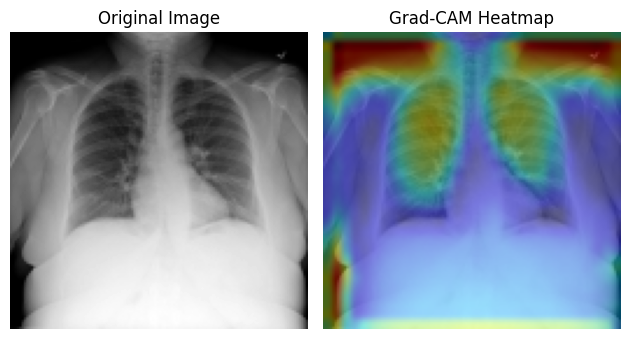

Sample Index: 125, True Label: 1.0, Predicted Label: 1


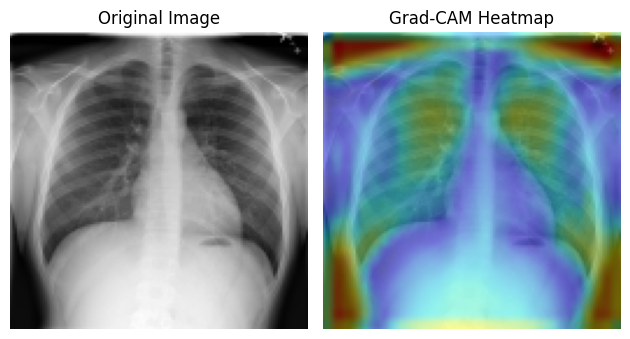

In [188]:
# Extract a few samples from each group and visualize their Grad-CAM explanations.

def visualize_gradcam_for_groups(groups, all_test_images, all_test_labels, model, num_samples=3):
    for i, group in enumerate(groups, start=1):
        print(f"\nVisualizing Grad-CAM for Group {i}...")
        for idx in random.sample(sorted(group), num_samples):  # Limit to `num_samples` per group
            test_image = all_test_images[idx]
            true_label = all_test_labels[idx]
            
            # Preprocess the image for the model
            input_image = tf.expand_dims(test_image, axis=0)
            
            # Generate Grad-CAM heatmap
            heatmap = make_gradcam_heatmap(input_image, model)
            
            # Display the Grad-CAM heatmap
            print(f"Sample Index: {idx}, True Label: {true_label}, Predicted Label: {pred_labels[idx]}")
            display_gradcam(test_image, heatmap)

# Define the groups
groups = [group_1, group_2, group_3, group_4]

# Visualize Grad-CAM explanations for each group
visualize_gradcam_for_groups(groups, all_test_images, all_test_labels, model)

## Questions

**Question 19:** *Did you have to modify the algorithm to account for a scalar output? If so, how did you modify it?*

Because our model outputs a single sigmoid logit rather than a full vector of class scores, we removed the final activation so we'd get an unsquashed logit and then treated that scalar as the "class score" when computing gradients. Otherwise, the core Grad‑CAM steps remain unchanged.

---

**Question 20:** *Do you think that having only two class labels affects the explanation? If you do, how so?*

With only two labels, Grad‑CAM highlights simply show which regions push the model toward "positive" versus "negative." There's no need to compare multiple classes, so the heatmap directly reflects the single decision boundary, which makes interpretation simpler but less nuanced than in a multiclass setting.

---

**Question 21:** *Do the Grad-CAM visualizations highlight medically relevant areas in the X-ray, such as lung opacities or other features indicative of COVID-19?*

In well‑trained cases, the heatmaps tend to light up lung regions where COVID‑related opacities appear (e.g., ground‑glass patterns or consolidations). If we see activations outside the lungs, that can signal the model is focusing on the wrong features.

---

**Question 22:** *Did Grad-CAM visualizations help you identify potential biases in the model?*

Yes—by inspecting where the model focuses, we can spot biases. For example, if Grad‑CAM repeatedly highlights text labels, borders, or equipment artifacts instead of lung tissue, that indicates the model is learning shortcuts tied to dataset artifacts rather than true pathology.

---

**Question 23:** *Was Grad-CAM useful for understanding the model’s misclassifications?*

Grad‑CAM is especially helpful for misclassifications: for false positives it often lights up benign findings (like old scars), and for false negatives it shows when the model simply missed subtle opacities. Seeing these patterns guides us to understand exactly why a sample was mistaken.

---

**Question 24:** *Consider a scenario in which you can collect additional data and retrain the model. Would you change anything based on the Grad-CAM explanations?*

Based on Grad‑CAM insights, I’d collect more examples of under‑represented disease patterns (e.g., peripheral opacities), remove or crop out distracting artifacts (like text markers), and balance data from different hospitals. This targeted data curation and augmentation would help the model learn to focus properly on medically relevant lung features.
